In [559]:
%matplotlib inline

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import psana
from tqdm import tqdm
from pathlib import Path
from utilities import *
from crosscor import *
from scipy.optimize import curve_fit

In [50]:
def gaussian(x, amp, cen, wid, bg):
                return amp * np.exp(-(x-cen)**2 /(2*wid**2))+bg
    
def fit_gaussian1_curveFit(a, shot_id=None, ax=None, n=20, pdel=3, printflag=False, plotflag=True, color='blue', tol=0.4, label=None):
    x = np.arange(2*n)-n
    aroi = a.copy()
    x,z = makeFittingData(x,aroi,pdel = pdel)
    p0 = np.array([1.,0.,3.,1.])
    px,covx = curve_fit(gaussian,x, z ,p0)
    perr = np.nanmean(np.sqrt(np.diag(covx)))
    if plotflag:
        if ax is None:
            fig, ax = plt.subplots(tight_layout=True)
        else:
            xplot = np.linspace(0,n*2,600)-n
            zplot = gaussian(xplot,*px)
            ax.plot(xplot,zplot,color = color)
            x = np.arange(2*n)-n
            aroi = a.copy()   
            x,z = makeFittingData(x,aroi,pdel = pdel)
            ax.plot(x,z,'o',color = color, label=label)
            ax.set_xlabel('distance (pixel)')
            ax.set_ylabel('correlation')
            ax.set_title(f'shot_id: {shot_id}')
            ax.legend()
    return px

def makeFittingData(x,z,pdel =3):
    for i in np.arange(pdel):
        z[z.argmax()] = 0
    ind = np.where(z>0)[0]
    x_pick = x[ind]
    z_pick = z[ind]
    return x_pick,z_pick

def getSpeckleProperties(f,E = 9.83, L = 5.43,ps = 50e-6):
    lam = 12.398/E
    width = f[2]*2.35
    s = 0.9*lam*L/(width*ps)*1e-10
    return width, s

In [139]:
# smalldata path
exp = 'xppl1001021'
p = Path('/sdf/data/lcls/ds/{}/{}'.format(exp[:3], exp))
smalldata = Path(p, 'hdf5', 'smalldata')
epix2_data = Path(p, 'hdf5', 'smalldata', 'epix2_only')
results = Path(p, 'results')
shared = Path(results, 'shared')
jungfrau_iq = Path(shared, 'jungfrau_Iq')
print('Smalldata path exists:', jungfrau_iq.exists())
print('Jungfrau path exists:', jungfrau_data.exists())
print('epix2 path exists:', epix2_data.exists())

def getDelays(f):
    with h5py.File(f) as h5:
        return h5['delay_ps'][:1000:100]

def getDelaysFromSmd(f):
    with h5py.File(f) as h5:
        return 0.939 * (h5['/epicsAll/sd_delay'][:1000:100] - 6.95)


Smalldata path exists: True
Jungfrau path exists: True
epix2 path exists: True


In [159]:
run = 82


delays = getDelaysFromSmd(Path(smalldata, f'{exp}_Run{run:04d}.h5'))
delays

array([0.2347547 , 0.2347547 , 0.2347547 , 0.23475   , 0.2347547 ,
       0.23475939, 0.23475   , 0.23475   , 0.23475   , 0.2347547 ])

In [160]:

nimg = int(1000 / 100) + 1
print(nimg)

11


In [161]:
ds = psana.MPIDataSource('exp=xppl1001021:run={}:smd'.format(run))

detname = 'epix_alc5'
det = psana.Detector(detname)
crl_z_det = psana.Detector('crl_z') 
crl_x_det = psana.Detector('crl_x')
crl_y_det = psana.Detector('crl_y')

# instansiate some stuff
di = 0
counter = 0
crl_z_values = np.zeros((nimg,))
crl_x_values = np.zeros((nimg,))
crl_y_values = np.zeros((nimg,))



for nevt,evt in tqdm(enumerate(ds.events())):
    
    # only take first 1000 shots to do some quick data analysis
    if nevt > 1000: break
    
    # get crl values
    crl_z = crl_z_det(evt)
    crl_x = crl_x_det(evt)
    crl_y = crl_y_det(evt)
    img = det.calib(evt)
    
    # instansiate images for averaging
    if counter == 0:
        imgs = np.zeros(np.r_[nimg, img.shape])
        _tmp_imgs = np.zeros(img.shape)
    else:
        _tmp_imgs += img
    if nevt % 100 == 0:
        crl_z_values[counter] = crl_z
        imgs[counter] = _tmp_imgs.copy() / 1200
        _tmp_imgs = np.zeros(img.shape)
        crl_z_values[counter] = crl_z
        crl_x_values[counter] = crl_x
        crl_y_values[counter] = crl_y
        counter += 1

1001it [00:36, 27.57it/s]


In [162]:
crl_z_values.shape

(11,)

### average image analysis

In [163]:
imgs.shape

(11, 704, 768)

In [164]:
aimg = np.mean(imgs, axis = 0)

In [165]:
roi = np.zeros((aimg.shape))
roi[380:460,500:560] = 1
roi[490:560, 260:320] = 2
roi[260:320, 500:560] = 3
roi[150:210, 310:370] = 4

cc = crosscor(roi.shape, roi, 'symavg')

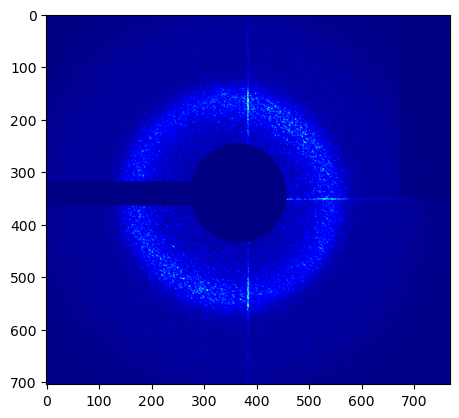

In [166]:
plt.figure()
plt.imshow(aimg, vmax = 5, cmap = 'jet')

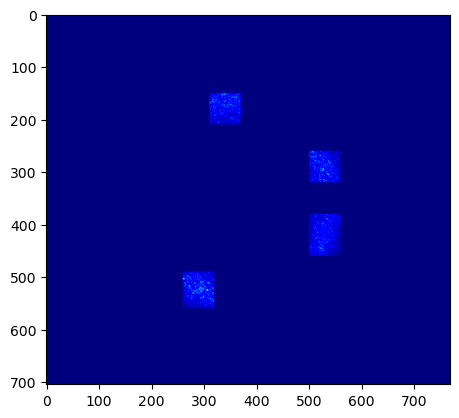

In [167]:
plt.figure()
plt.imshow(aimg*roi.astype(bool), cmap='jet', vmax = 5)

In [168]:
roi.shape

(704, 768)

### Mean AC

In [169]:
l = 20
autocorr = cc(aimg)
autocorr_center = np.zeros((int(roi.max()), 2*l, 2*l))
for i in range(int(roi.max())):
    ashape = autocorr[i].shape
    autocorr_center[i] = autocorr[i][ashape[0]//2-l:ashape[0]//2+l, ashape[1]//2-l:ashape[1]//2+l]

In [170]:
ave_autocorr = np.mean(autocorr_center, axis = 0)

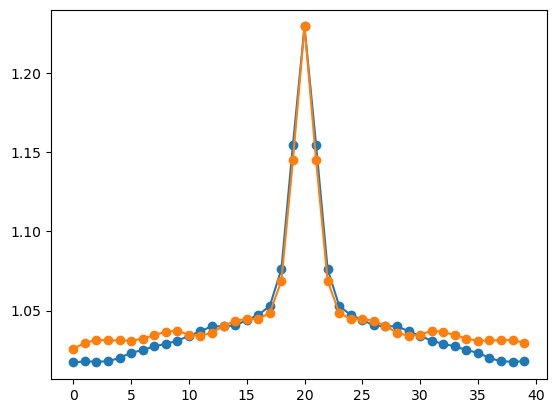

In [171]:
plt.figure()
plt.plot(ave_autocorr[l, :], 'o-')
plt.plot(ave_autocorr[:, l], 'o-')

###  single shot analyis

In [172]:
middle_index = 20
autocorr_center_single_img = np.zeros((nimg, 4, 2*middle_index, 2*middle_index))
ints = np.zeros((nimg))
for i in range(nimg):
    _autocorrs = cc(imgs[i])
    ints[i] = imgs[i][roi == 1].mean()
    for roi_index in range(4):
        autocorr_shape = _autocorrs[roi_index].shape
        autocorr_center_single_img[i, roi_index] = _autocorrs[roi_index][
            autocorr_shape[0]//2-l:autocorr_shape[0]//2+l, autocorr_shape[1]//2-l:autocorr_shape[1]//2+l
        ]

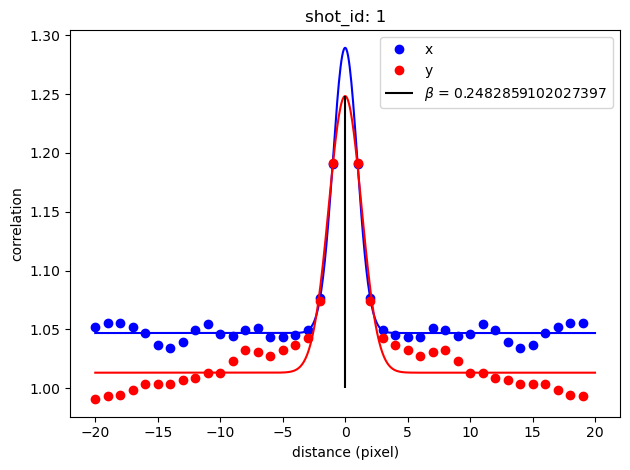

shot_id = 1, S: 2.30 pixel, 3.06 pixel, d 4.41161 micron, 3.31976 micron


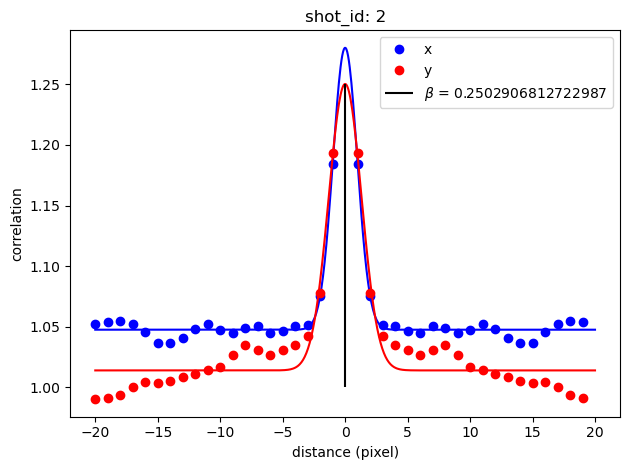

shot_id = 2, S: 2.28 pixel, 3.08 pixel, d 4.44851 micron, 3.29415 micron


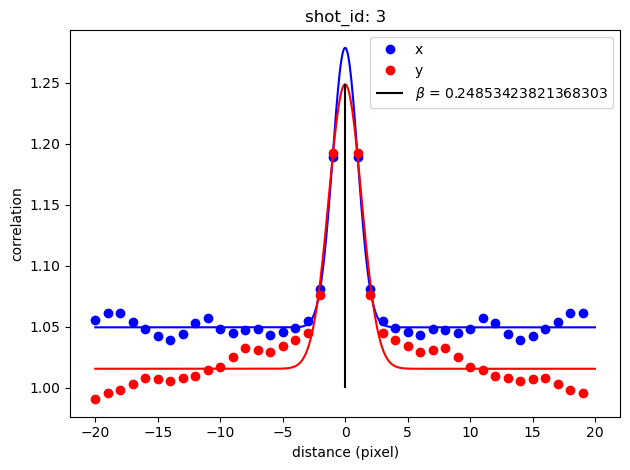

shot_id = 3, S: 2.36 pixel, 3.06 pixel, d 4.30082 micron, 3.32035 micron


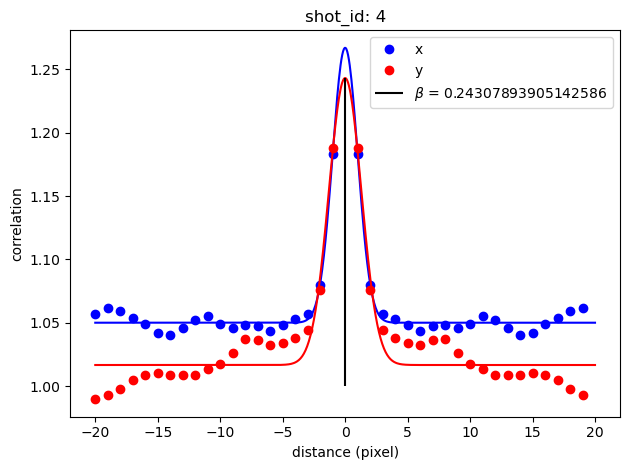

shot_id = 4, S: 2.38 pixel, 3.06 pixel, d 4.26867 micron, 3.31980 micron


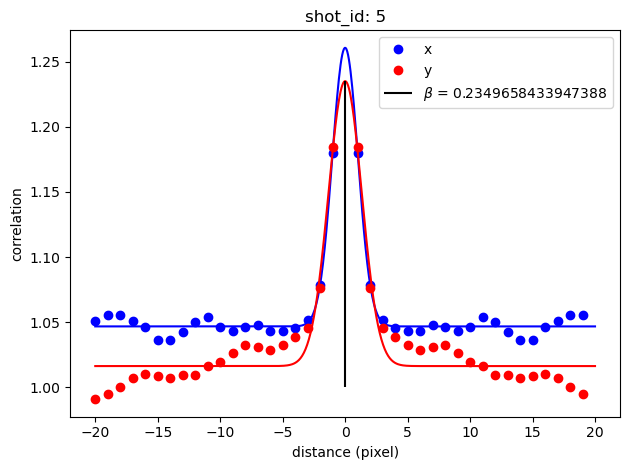

shot_id = 5, S: 2.41 pixel, 3.14 pixel, d 4.20318 micron, 3.23674 micron


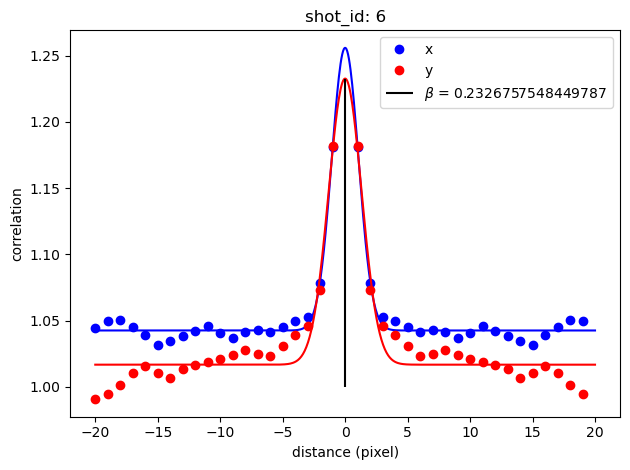

shot_id = 6, S: 2.52 pixel, 3.09 pixel, d 4.02529 micron, 3.28202 micron


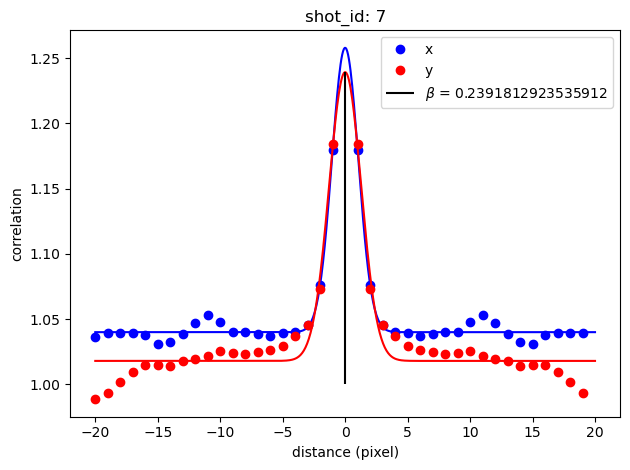

shot_id = 7, S: 2.48 pixel, 3.01 pixel, d 4.08626 micron, 3.36887 micron


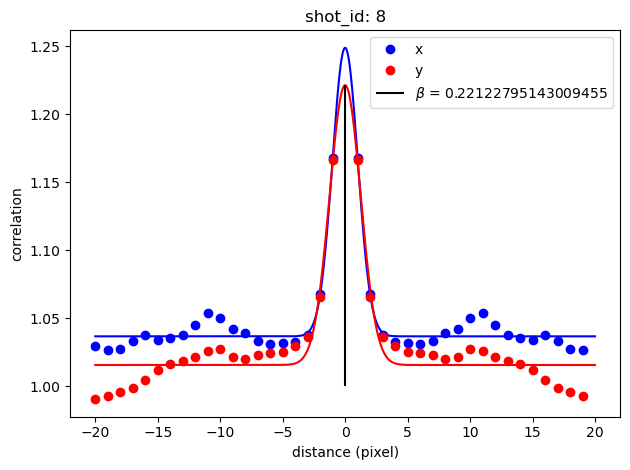

shot_id = 8, S: 2.39 pixel, 2.92 pixel, d 4.24532 micron, 3.47587 micron


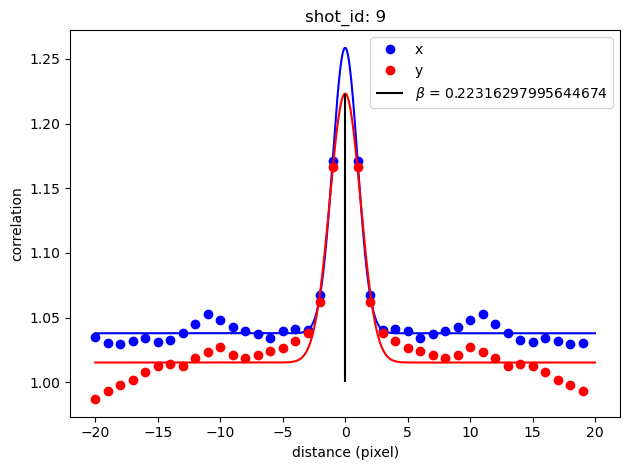

shot_id = 9, S: 2.34 pixel, 2.88 pixel, d 4.33197 micron, 3.52822 micron


In [173]:
# select the autocorrelations of a single roi
roi_autocorr = autocorr_center_single_img[:, 2, :, :]
beam_size = np.zeros([2, nimg])
contrasts = []
contrasts_error = []
for i in range(nimg-1):
    if i == 0:
        continue
    # select autocorrelation of a single frame
    single_img_autocorr = roi_autocorr[i]
    try:
        xplot = np.linspace(0,20*2,600)-20
        # fit autocorrelation with gaussian
        fig, ax = plt.subplots(tight_layout=True)
        fh = fit_gaussian1_curveFit(
            single_img_autocorr[:, middle_index], 
            n=middle_index, pdel=1, plotflag=True, 
            ax=ax, tol=0.5, shot_id=i, color='blue', label='x'
        )
        fv = fit_gaussian1_curveFit(
            single_img_autocorr[middle_index, :], 
            n=middle_index, pdel=1, plotflag=True, 
            ax=ax, tol=0.5, shot_id=i, color='red', label='y'
        )
        
        zplot_h = gaussian(xplot,*fh)
        zplot_v = gaussian(xplot,*fv)
        contrast = zplot_v.max() - 1
        contrasts.append(contrast)
        contrasts_error.append(zplot_v.std() / np.sqrt(len(zplot_v)))
        ax.vlines(0, 1, contrast+1, color='k', label=rf"$\beta$ = {contrast}")
        ax.legend()
        plt.show()
        
        # if fit produces nans raise error
        if np.isnan(np.mean(fh)) or np.isnan(np.mean(fv)):
            raise RuntimeError
        
        # get beam size
        widthx, beamx= getSpeckleProperties(fh, E = 9.5, L = 4.32,ps = 50e-6)
        widthy, beamy = getSpeckleProperties(fv, E = 9.5, L = 4.32,ps = 50e-6)
        
        # if beamsize is negative fill with nans
        if beamx < 0:
            beamx = np.nan
        if beamy < 0:
            beamy = np.nan
        
    # if fit doesnt work fill with nan values
    except RuntimeError:
        beamx = np.nan
        beamy = np.nan
    
    beam_size[0][i] = beamx
    beam_size[1][i] = beamy
    
    print('shot_id = {:01d}, S: {:.2f} pixel, {:.2f} pixel, d {:.5f} micron, {:.5f} micron'.format(i, widthx, widthy, beamx*1e6, beamy*1e6))

## CRL analysis

In [642]:
# smalldata path
exp = 'xppl1001021'
p = Path('/sdf/data/lcls/ds/{}/{}'.format(exp[:3], exp))
smalldata = Path(p, 'hdf5', 'smalldata')
jungfrau_data = Path(p, 'hdf5', 'smalldata', 'jungfrau')
results = Path(p, 'results')
shared = Path(results, 'shared')
print('Smalldata path exists:', smalldata.exists())
print('Jungfrau path exists:', jungfrau_data.exists())

Smalldata path exists: True
Jungfrau path exists: True


In [643]:
# Average beam sizes for every crl
_tmp_beam_size_x = np.split(beam_size[0], np.unique(crl_z_values, return_index=True)[1])[1:]
tmp_beam_size_x = np.asarray([np.nanmean(_tmp_beam_size_x[i]) for i in range(len(_tmp_beam_size_x))])

_tmp_beam_size_y = np.split(beam_size[1], np.unique(crl_z_values, return_index=True)[1])[1:]
tmp_beam_size_y = np.asarray([np.nanmean(_tmp_beam_size_y[i]) for i in range(len(_tmp_beam_size_y))])


_tmp_crl_z = np.split(crl_z_values, np.unique(crl_z_values, return_index=True)[1])[1:]
tmp_crl_z = np.asarray([np.nanmean(_tmp_crl_z[i]) for i in range(len(_tmp_crl_z))])

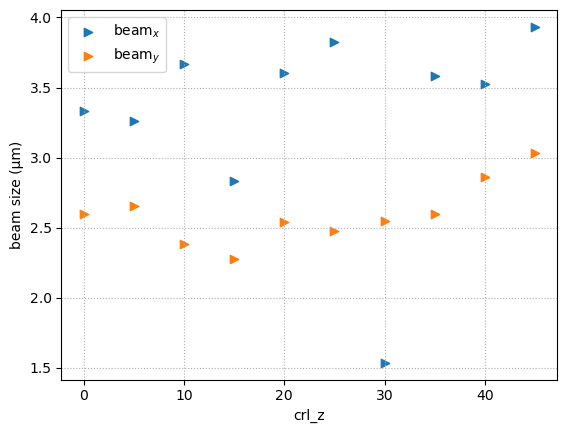

In [644]:
# plt.scatter(tmp_crl_z, tmp_beam_size_x*1e6, label="beam$_x$")
# plt.scatter(tmp_crl_z, tmp_beam_size_y*1e6, label="beam$_y$")
plt.scatter(crl_z_values[np.where(beam_size[0] > 0.)], beam_size[0][np.where(beam_size[0] > 0.)]*1e6, marker='>', label="beam$_x$")
plt.scatter(crl_z_values[np.where(beam_size[1] > 0.)], beam_size[1][np.where(beam_size[1] > 0.)]*1e6, marker='>', label="beam$_y$")
plt.grid(linestyle=":")
plt.xlabel("crl_z")
plt.ylabel("beam size (μm)")
plt.legend()
plt.show()

## Contrast vs Delay

In [153]:
len(contrasts), len(contrasts_error), delays.size

(9, 9, 10)

In [156]:
import xarray as xr

contrast_xr = xr.DataArray(contrasts).assign_coords({'dim_0':delays[1:]}).rename({'dim_0':'delay'})

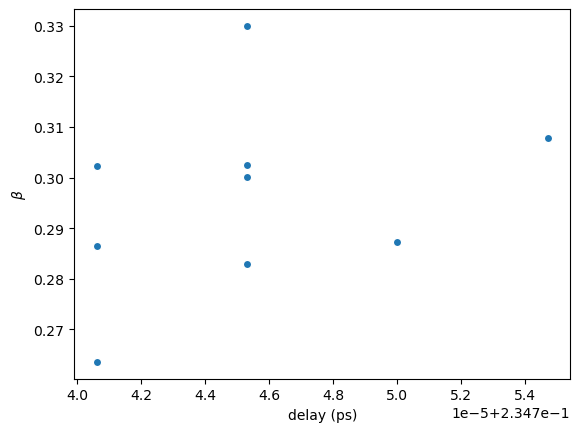

In [158]:
contrast_xr.plot.scatter()
plt.xlabel("delay (ps)")
plt.ylabel(r"$\beta$")
plt.show()

In [124]:
mean_contrast_xr = peak_xr.groupby_bins('delay',70).mean()
mean_contrast_xr

<xarray.DataArray (delay_bins: 70)>
array([0.25830629,        nan,        nan,        nan,        nan,
              nan,        nan, 0.27087839,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.27206443,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.28071148,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.27417584,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.30723188,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.28165308,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.29867967,        nan,        nan,
              nan,        nan,        nan,        nan, 0.26426421])
Coordinates:
  * delay_bins  (delay_bins) object (0.769, 0.779] ... (1.382, 1.391]

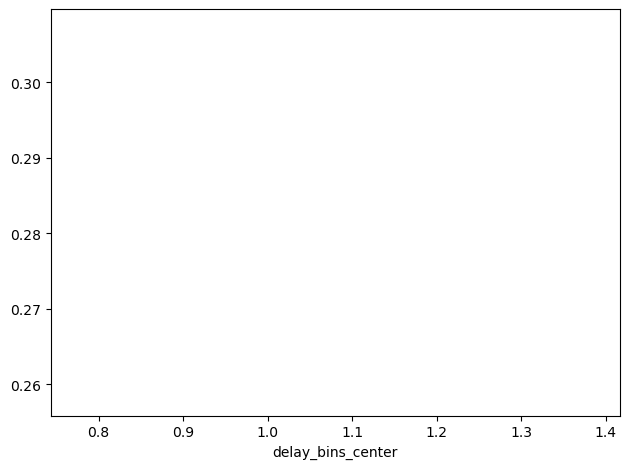

In [123]:
fig, ax = plt.subplots(tight_layout=True)
x = mean_contrast_xr.values
bins = [mean_contrast_xr.delay_bins.values[i].mid for i in range(len(x))]
mean_contrast_xr.plot()
# ax.set_xlabel("delay (ps)")
# ax.set_ylabel(r"$q (\AA^{-1})$")
# ax.xaxis.set_major_formatter('{x:.1f}')
plt.show()